# DoG + Harris Keypoints (Notebook)

Notebook này triển khai tìm **điểm bất biến theo tỉ lệ** bằng **Difference of Gaussian (DoG)**
kết hợp **đáp ứng Harris** để nhấn mạnh các điểm góc mạnh.

**Tính năng bổ sung:**
- Lưu **keypoints** ra file CSV (`keypoints.csv`)
- Lưu ảnh **overlay** hiển thị keypoints
- Xuất **Harris heatmaps** theo từng mức Gaussian trong mỗi octave (mỗi heatmap là *một hình riêng*, không dùng subplot)

> Yêu cầu: `opencv-python`, `numpy`, `matplotlib`.


In [2]:
# !pip install opencv-python numpy matplotlib

import os
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Thư mục đầu ra
OUT_DIR = Path('D:/Teach_n_Train/Advanced_Lessons_CV/LABS/Local_Feature/dog_harris_outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('Output dir:', OUT_DIR.resolve())

# Tham số mặc định
SIGMA0 = 1.6
SCALES_PER_OCT = 3
NUM_OCTAVES = 4
CONTRAST_TH = 0.03
EDGE_R = 10
HARRIS_K = 0.04
HARRIS_REL_TH = 0.01
NMS_RADIUS = 3
DRAW_SIZE = 3

def gaussian_blur(img, sigma):
    ksize = max(3, int(np.ceil(sigma*6))|1)
    return cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REPLICATE)

def build_gaussian_pyramid(gray, num_octaves=NUM_OCTAVES, s=SCALES_PER_OCT, sigma0=SIGMA0):
    base = gray.astype(np.float32) / 255.0
    k = 2 ** (1.0 / s)
    gauss_pyr, sigmas_pyr = [], []
    for o in range(num_octaves):
        octave_imgs, octave_sigmas = [], []
        sigmas = [sigma0 * (k**i) for i in range(s + 3)]
        if o == 0:
            prev = gaussian_blur(base, np.sqrt(max(sigmas[0]**2 - 0.5**2, 1e-6)))
        else:
            prev = cv2.resize(gauss_pyr[o-1][s], (base.shape[1] >> o, base.shape[0] >> o), interpolation=cv2.INTER_NEAREST)
        octave_imgs.append(prev); octave_sigmas.append(sigmas[0])
        for i in range(1, s+3):
            sigma_prev, sigma_curr = sigmas[i-1], sigmas[i]
            sigma_inc = np.sqrt(max(sigma_curr**2 - sigma_prev**2, 1e-6))
            blur = gaussian_blur(octave_imgs[-1], sigma_inc)
            octave_imgs.append(blur); octave_sigmas.append(sigmas[i])
        gauss_pyr.append(octave_imgs); sigmas_pyr.append(octave_sigmas)
    return gauss_pyr, sigmas_pyr

def build_dog_pyramid(gauss_pyr):
    dog_pyr = []
    for octave_imgs in gauss_pyr:
        dogs = [octave_imgs[i] - octave_imgs[i-1] for i in range(1, len(octave_imgs))]
        dog_pyr.append(dogs)
    return dog_pyr

def is_local_extrema(cube):
    c = cube[1,1,1]
    if c > 0:
        return c == cube.max()
    else:
        return c == cube.min()

def pass_edge_response(dog, y, x, r=EDGE_R):
    Dxx = dog[y, x+1] + dog[y, x-1] - 2*dog[y, x]
    Dyy = dog[y+1, x] + dog[y-1, x] - 2*dog[y, x]
    Dxy = (dog[y+1, x+1] - dog[y+1, x-1] - dog[y-1, x+1] + dog[y-1, x-1]) * 0.25
    Tr = Dxx + Dyy
    Det = Dxx*Dyy - Dxy*Dxy
    if Det <= 0:
        return False
    ratio = (Tr*Tr) / Det
    rcrit = ((r + 1.0)**2) / r
    return ratio < rcrit

def harris_response(img, k=HARRIS_K, win_sigma=1.0):
    Ix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REPLICATE)
    Iy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REPLICATE)
    Ixx, Iyy, Ixy = Ix*Ix, Iy*Iy, Ix*Iy
    Sxx = gaussian_blur(Ixx, win_sigma)
    Syy = gaussian_blur(Iyy, win_sigma)
    Sxy = gaussian_blur(Ixy, win_sigma)
    detM = Sxx*Syy - Sxy*Sxy
    traceM = Sxx + Syy
    R = detM - k*(traceM**2)
    return R

def nonmax_suppression(points, radius):
    if not points:
        return []
    pts = np.array(points)
    order = np.argsort(-pts[:,2])
    kept, taken = [], np.zeros(len(points), dtype=bool)
    for i in order:
        if taken[i]:
            continue
        yi, xi, _ = pts[i]
        kept.append(points[i])
        dy = pts[:,0] - yi
        dx = pts[:,1] - xi
        mask = (dx*dx + dy*dy) <= (radius*radius)
        taken = taken | mask
    return kept

def detect_keypoints_dog_harris(gray,
                                num_octaves=NUM_OCTAVES,
                                s=SCALES_PER_OCT,
                                sigma0=SIGMA0,
                                contrast_th=CONTRAST_TH,
                                edge_r=EDGE_R,
                                harris_k=HARRIS_K,
                                harris_rel_th=HARRIS_REL_TH,
                                nms_radius=NMS_RADIUS):
    gauss_pyr, sigmas_pyr = build_gaussian_pyramid(gray, num_octaves, s, sigma0)
    dog_pyr = build_dog_pyramid(gauss_pyr)
    from collections import defaultdict
    buckets = defaultdict(list)

    for o in range(num_octaves):
        dogs = dog_pyr[o]
        gaussians = gauss_pyr[o]
        H, W = dogs[0].shape

        harris_list = []
        for gi in range(1, s+2):
            R = harris_response(gaussians[gi], k=harris_k, win_sigma=1.0)
            Rmax = float(np.max(R)) if R.size else 1.0
            thr = harris_rel_th * (Rmax if Rmax > 1e-12 else 1.0)
            harris_list.append((R, thr))

        for i in range(1, s+1):
            dog_prev, dog_curr, dog_next = dogs[i-1], dogs[i], dogs[i+1]
            R, R_thr = harris_list[i-1]
            for y in range(1, H-1):
                for x in range(1, W-1):
                    val = dog_curr[y, x]
                    if abs(val) < contrast_th:
                        continue
                    cube = np.stack([
                        dog_prev[y-1:y+2, x-1:x+2],
                        dog_curr[y-1:y+2, x-1:x+2],
                        dog_next[y-1:y+2, x-1:x+2]
                    ], axis=0)
                    if not is_local_extrema(cube):
                        continue
                    if not pass_edge_response(dog_curr, y, x, r=edge_r):
                        continue
                    Rh = R[y, x]
                    if Rh <= R_thr:
                        continue
                    buckets[(o, i)].append((y, x, float(Rh)))

    final_points = []
    for (o, i), pts in buckets.items():
        kept = nonmax_suppression(pts, radius=nms_radius)
        scale_factor = (2 ** o)
        for (y, x, sc) in kept:
            x0 = int(x * scale_factor)
            y0 = int(y * scale_factor)
            sigma = SIGMA0 * (2 ** (o + i / float(SCALES_PER_OCT)))
            final_points.append({
                'x': x0, 'y': y0,
                'octave': o, 'scale_index': i,
                'sigma': float(sigma),
                'score': float(sc)
            })
    return final_points, gauss_pyr

def draw_keypoints(img_bgr, kps):
    out = img_bgr.copy()
    for kp in kps:
        cv2.circle(out, (int(kp['x']), int(kp['y'])), DRAW_SIZE, (0,255,0), 1, lineType=cv2.LINE_AA)
    return out

def save_keypoints_csv(kps, csv_path):
    import csv
    with open(csv_path, 'w', newline='', encoding='utf-8') as f:
        w = csv.DictWriter(f, fieldnames=['x','y','octave','scale_index','sigma','score'])
        w.writeheader()
        for kp in kps:
            w.writerow(kp)
    print('Saved keypoints CSV:', csv_path)

def export_harris_heatmaps(gauss_pyr, out_dir=OUT_DIR):
    out_heat_dir = out_dir / 'harris_heatmaps'
    out_heat_dir.mkdir(parents=True, exist_ok=True)
    count = 0
    for o, octave_imgs in enumerate(gauss_pyr):
        s = SCALES_PER_OCT
        for gi in range(1, s+2):
            g = octave_imgs[gi]
            R = harris_response(g, k=HARRIS_K, win_sigma=1.0)
            Rn = R.copy()
            if Rn.size:
                mn, mx = float(Rn.min()), float(Rn.max())
                if mx > mn:
                    Rn = (Rn - mn) / (mx - mn)
                else:
                    Rn = np.zeros_like(Rn)
            plt.figure()
            plt.imshow(Rn)
            plt.title(f'Harris Heatmap - Octave {o} - Gaussian idx {gi}')
            plt.axis('off')
            fname = out_heat_dir / f'harris_oct{o}_g{gi}.png'
            plt.savefig(fname, bbox_inches='tight', pad_inches=0)
            plt.close()
            count += 1
    print(f'Saved {count} heatmap image(s) to:', out_heat_dir.resolve())


Output dir: D:\Teach_n_Train\Advanced_Lessons_CV\LABS\Local_Feature\dog_harris_outputs


## 1) Nạp ảnh & phát hiện keypoints

- Sửa biến `IMAGE_PATH` để trỏ đến ảnh của bạn.
- Các tệp đầu ra sẽ xuất vào thư mục `./dog_harris_outputs`:
  - `keypoints.csv`
  - `overlay_keypoints.png`
  - `harris_heatmaps/*.png`


Số keypoints phát hiện: 217
Saved keypoints CSV: D:\Teach_n_Train\Advanced_Lessons_CV\LABS\Local_Feature\dog_harris_outputs\keypoints.csv
Saved overlay: D:\Teach_n_Train\Advanced_Lessons_CV\LABS\Local_Feature\dog_harris_outputs\overlay_keypoints.png
Saved 16 heatmap image(s) to: D:\Teach_n_Train\Advanced_Lessons_CV\LABS\Local_Feature\dog_harris_outputs\harris_heatmaps


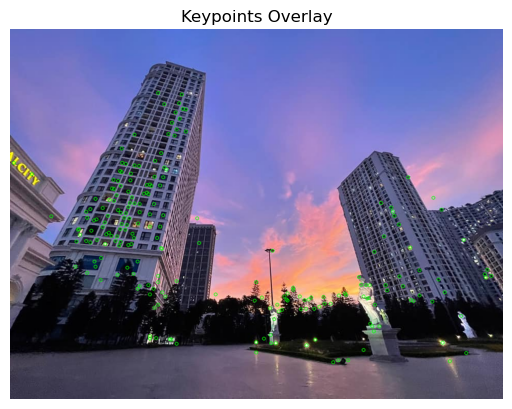

In [3]:
# Đặt đường dẫn ảnh đầu vào ở đây:
IMAGE_PATH = 'D:/Teach_n_Train/Advanced_Lessons_CV/LABS/Local_Feature/IMG1724.jpg'  # <-- thay bằng ảnh của bạn

# Đọc ảnh
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
if img is None:
    raise FileNotFoundError(f'Không mở được ảnh: {IMAGE_PATH}')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Phát hiện keypoints + lấy gaussian pyramid để vẽ heatmap Harris
kps, gauss_pyr = detect_keypoints_dog_harris(gray)
print(f'Số keypoints phát hiện: {len(kps)}')

# Lưu CSV keypoints
csv_path = OUT_DIR / 'keypoints.csv'
save_keypoints_csv(kps, csv_path)

# Lưu ảnh overlay
overlay = draw_keypoints(img, kps)
overlay_path = OUT_DIR / 'overlay_keypoints.png'
cv2.imwrite(str(overlay_path), overlay)
print('Saved overlay:', overlay_path.resolve())

# Xuất heatmaps Harris (mỗi heatmap là một ảnh riêng)
export_harris_heatmaps(gauss_pyr, out_dir=OUT_DIR)

# Hiển thị nhanh overlay trong notebook (một hình riêng)
plt.figure()
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Keypoints Overlay')
plt.axis('off')
plt.show()


## 2) Tuỳ chỉnh tham số (tuỳ chọn)

Bạn có thể chạy lại ô dưới để điều chỉnh tham số phát hiện rồi thử lại ô phát hiện phía trên.


In [ ]:
# Điều chỉnh tham số toàn cục (tuỳ chọn), sau đó chạy lại cell phát hiện:
SIGMA0 = 1.6
SCALES_PER_OCT = 3
NUM_OCTAVES = 4
CONTRAST_TH = 0.03
EDGE_R = 10
HARRIS_K = 0.04
HARRIS_REL_TH = 0.01
NMS_RADIUS = 3
DRAW_SIZE = 3

print('Tham số đã cập nhật (nếu cần).')
